In [1]:
#### Import required libraries
import os
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from operator import itemgetter
from typing import Dict, Tuple, List, Set

### nltk
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
import dataclasses
from nltk import word_tokenize
from nltk.corpus import stopwords 
import string 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import movie_reviews
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
from random import shuffle

## sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


## gensim 
import gensim
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.corpora import Dictionary
import gensim.downloader as api
from gensim.models import Word2Vec as w2v
from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors

## tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional, Activation
from tensorflow.keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Build the classification model using the following dataset

https://www.kaggle.com/datasets/matleonard/nlp-course?select=spam.csv 

1. Classify text as spam/not using bag-of-words methods 

2. Use NN models to predict whether the text is spam or not?\
Preprocess the text data and perform EDA\
Use pre-trained Word2vec/FastText/GloVe\
LSTM model\
Bi-LSTM model\
Bi-LSTM with attention layer

3. Compare and conclude your model performance results for these models. How do you productionalize your model along with your dataset (product your thoughts)? 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
spam_dataset = pd.read_csv('/content/drive/MyDrive/SemesterTwo/IE7374/Assignment3/Assignment3Data/spam.csv')
spam_dataset

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


# **Preprocessing and EDA**

In [4]:
spam_dataset.isnull().sum()

label    0
text     0
dtype: int64

The dataset is not having any null values.

In [5]:
len(spam_dataset)

5572

In [6]:
spam_dataset['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

The dataset is skewed data. Unbalanced data can not be directly passed to classification Machine Learning model.

As the datasset is not balanced we need some preprocessing on the dataset otherwise the accuracy will be affected.

#### **Count Plot**

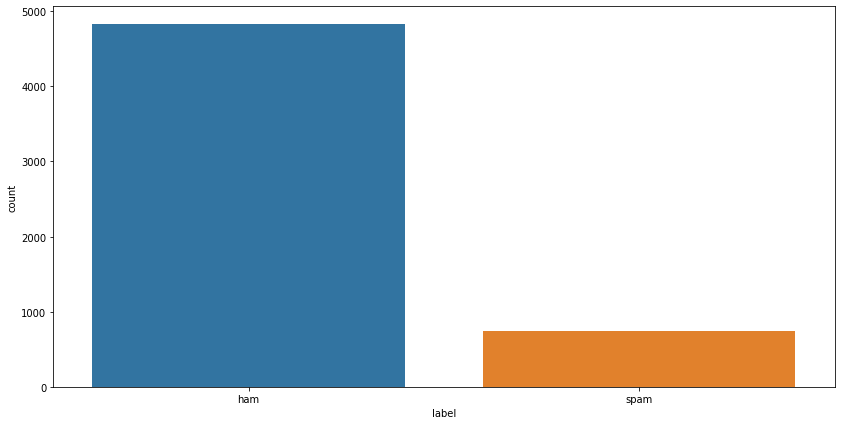

In [7]:
plt.figure(figsize = (14, 7))
sns.countplot(x=spam_dataset['label'], data = spam_dataset)
plt.show()

#### **Label encoder**

In [8]:
labelencoder = LabelEncoder()
spam_dataset['label'] = labelencoder.fit_transform(spam_dataset['label'])
spam_dataset
## 1 = spam
## 0 = ham


,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [9]:
class TextProcessor :

  #### Lower Casing
  def lowerCasing(self, total_dataset):
    return total_dataset.text.apply(lambda x: " ".join(x.lower() for x in x.split()))

  #### Punctuation Removal
  def removePunctuation(self, text):
    for punctuation in string.punctuation:
        text = text.str.replace(punctuation, '')
    return text

  #### Identifying and Removing Stop Words
  def removeStopWords(self, data):
    stop_words = stopwords.words('english')
    sw_list = ['ur','u','1','2','3','4','5','6','7','8','9','0','im']
    stop_words.extend(sw_list)
    return data.apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

  #### Tokenize Text in Words
  def tokenizeTextWords(self, data):
    return data.apply(lambda x: word_tokenize(x))

  #### NLTK word Stemming
  def wordStemming(self, tockenized_data):
    stemmer = PorterStemmer()
    return tockenized_data.apply(lambda x: [stemmer.stem(word) for word in x])
    ## stemmer expects tokenized data as input
   
  #### Lemmatizing words using WordNet
  def wordNetLemmatizer(self, tockenized_data):
    lemmatizer = WordNetLemmatizer()
 
    ## Lemmatizer expects tokenized data as input
    ## Lemmmatizer expects the part of speech with each word
    ## Use part of speech tagging with word
    ## thus it will reduce down the words properly
    return tockenized_data.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

  #### Plotting Frequencies of Words
  def plotWordFrequency(self, lemmatized_data):

    ## extract all words in list
  
    word_review_list = lemmatized_data.tolist()
    all_words = [item for sublist in word_review_list for item in sublist]
    ## initialize the frequency counter
    word_counter = Counter(all_words)

    most_common_words = word_counter.most_common()[:10]
    most_common_words = pd.DataFrame(most_common_words)
    most_common_words.columns = ['word', 'freq']
    plt.figure(figsize=(14,7))
    most_common_words.sort_values(by='freq',ascending=True).plot(x='word', kind='barh')
    plt.show()

In [10]:
## In order to do an appropriate analysis, punctuation is removed, case is lowered and preprocessing is done using TextProcessor class methods
## creating object of text processor class to call its methods
textProcessorObject = TextProcessor()

In [11]:
## converting to lower case
spam_dataset['lowercase_text'] = textProcessorObject.lowerCasing(spam_dataset)
spam_dataset.head()

,label,text,lowercase_text
0,0,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ..."
1,0,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro..."


In [12]:
## removing punctuations
spam_dataset['remove_punctuation'] = textProcessorObject.removePunctuation(spam_dataset['lowercase_text'] )
spam_dataset.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  # Remove the CWD from sys.path while we load stuff.


,label,text,lowercase_text,remove_punctuation
0,0,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...",go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


In [13]:
## Removing stop words
spam_dataset['stopwords_removal'] = textProcessorObject.removeStopWords(spam_dataset['remove_punctuation'] )
spam_dataset.head()

,label,text,lowercase_text,remove_punctuation,stopwords_removal
0,0,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...",go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...,ok lar joking wif u oni,ok lar joking wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry wkly comp win fa cup final tkts 21s...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...,u dun say so early hor u c already then say,dun say early hor c already say
4,0,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,nah dont think goes usf lives around though


In [14]:
## text cleaning

#Preprovessing function to remove tags, html, special characters,and etc
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)
    
def preprocess_text(inputSentence):

    # Removing html tags
    sentence = remove_tags(inputSentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

     # Removing email address 
    sentence = re.sub(r'[^\s]+@[^*()\s]+', ' ', sentence)

     # Removing http address 
    sentence = re.sub(r'(http|https)://[^\s]*', ' ', sentence)

     # Removing dollar address 
    sentence = re.sub(r'[$]+', ' ', sentence)
    
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence


spam_dataset['processed_text'] = spam_dataset['stopwords_removal']
spam_dataset.processed_text.apply(lambda x : preprocess_text(x))


0       go jurong point crazy available bugis great wo...
1                                   ok lar joking wif oni
2       free entry wkly comp win fa cup final tkts 21s...
3                           dun say early hor already say
4             nah dont think goes usf lives around though
                              ...                        
5567    2nd time tried contact å£750 pound prize claim...
5568                            ì going esplanade fr home
5569                          pity mood soany suggestions
5570    guy bitching acted like id interested buying s...
5571                                       rofl true name
Name: processed_text, Length: 5572, dtype: object

In [15]:
## tockenize text in words
spam_dataset['tokens']  = textProcessorObject.tokenizeTextWords(spam_dataset['stopwords_removal'])
spam_dataset.head()

,label,text,lowercase_text,remove_punctuation,stopwords_removal,processed_text,tokens
0,0,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...",go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...,go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...,ok lar joking wif u oni,ok lar joking wif oni,ok lar joking wif oni,"[ok, lar, joking, wif, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry wkly comp win fa cup final tkts 21s...,free entry wkly comp win fa cup final tkts 21s...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...,u dun say so early hor u c already then say,dun say early hor c already say,dun say early hor c already say,"[dun, say, early, hor, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,nah dont think goes usf lives around though,nah dont think goes usf lives around though,"[nah, dont, think, goes, usf, lives, around, t..."


In [16]:
## perform stemming 
spam_dataset['stemmer']  = textProcessorObject.wordStemming(spam_dataset['tokens'])
spam_dataset.head()

,label,text,lowercase_text,remove_punctuation,stopwords_removal,processed_text,tokens,stemmer
0,0,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...",go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...,go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,0,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...,ok lar joking wif u oni,ok lar joking wif oni,ok lar joking wif oni,"[ok, lar, joking, wif, oni]","[ok, lar, joke, wif, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry wkly comp win fa cup final tkts 21s...,free entry wkly comp win fa cup final tkts 21s...,"[free, entry, wkly, comp, win, fa, cup, final,...","[free, entri, wkli, comp, win, fa, cup, final,..."
3,0,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...,u dun say so early hor u c already then say,dun say early hor c already say,dun say early hor c already say,"[dun, say, early, hor, c, already, say]","[dun, say, earli, hor, c, alreadi, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,nah dont think goes usf lives around though,nah dont think goes usf lives around though,"[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho..."


#### **Create the dictionary**

<Figure size 1008x504 with 0 Axes>

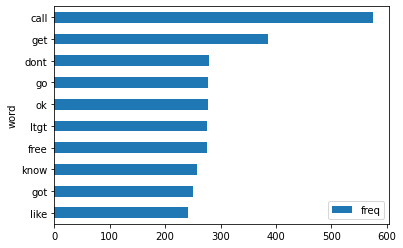

In [17]:
## plotting word frequency for top 10 words

textProcessorObject.plotWordFrequency(spam_dataset['tokens'])


In [18]:
#Word count per chap
spam_dataset['WordCount'] = spam_dataset['stemmer'].str.len()
spam_dataset.reset_index()

,index,label,text,lowercase_text,remove_punctuation,stopwords_removal,processed_text,tokens,stemmer,WordCount
0,0,0,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...",go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...,go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre...",16
1,1,0,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...,ok lar joking wif u oni,ok lar joking wif oni,ok lar joking wif oni,"[ok, lar, joking, wif, oni]","[ok, lar, joke, wif, oni]",5
2,2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry wkly comp win fa cup final tkts 21s...,free entry wkly comp win fa cup final tkts 21s...,"[free, entry, wkly, comp, win, fa, cup, final,...","[free, entri, wkli, comp, win, fa, cup, final,...",22
3,3,0,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...,u dun say so early hor u c already then say,dun say early hor c already say,dun say early hor c already say,"[dun, say, early, hor, c, already, say]","[dun, say, earli, hor, c, alreadi, say]",7
4,4,0,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,nah dont think goes usf lives around though,nah dont think goes usf lives around though,"[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho...",8
...,...,...,...,...,...,...,...,...,...,...
5567,5567,1,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,2nd time tried contact å£750 pound prize claim...,2nd time tried contact å£750 pound prize claim...,"[2nd, time, tried, contact, å£750, pound, priz...","[2nd, time, tri, contact, å£750, pound, prize,...",16
5568,5568,0,Will Ì_ b going to esplanade fr home?,will ì_ b going to esplanade fr home?,will ì b going to esplanade fr home,ì b going esplanade fr home,ì b going esplanade fr home,"[ì, b, going, esplanade, fr, home]","[ì, b, go, esplanad, fr, home]",6
5569,5569,0,"Pity, * was in mood for that. So...any other s...","pity, * was in mood for that. so...any other s...",pity was in mood for that soany other suggest...,pity mood soany suggestions,pity mood soany suggestions,"[pity, mood, soany, suggestions]","[piti, mood, soani, suggest]",4
5570,5570,0,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...,the guy did some bitching but i acted like id ...,guy bitching acted like id interested buying s...,guy bitching acted like id interested buying s...,"[guy, bitching, acted, like, id, interested, b...","[guy, bitch, act, like, id, interest, buy, som...",14


#### **Histplot**

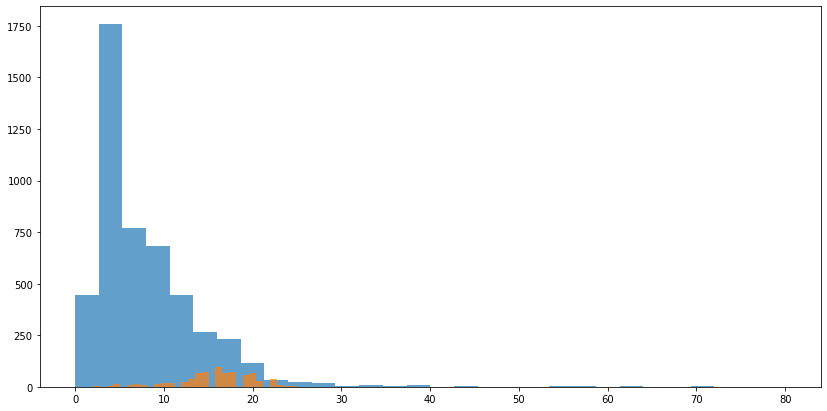

In [19]:
plt.figure(figsize=(14,7))
plt.hist(spam_dataset[spam_dataset['label']==0]['WordCount'], bins = 30, alpha = 0.7)
plt.hist(spam_dataset[spam_dataset['label']==1]['WordCount'], bins = 30, alpha = 0.7)
plt.show()

#### From this visualization, we can understand that the number of words in ham message is less than 10.

#### On the other hand the spam messages contain more words with average of 20 words.

#### Overall the spam messages have more words than the ham messages.

#### **WordCloud**

In [20]:
text = ' '.join(spam_dataset[spam_dataset["label"]==1]['stopwords_removal'].tolist())

In [21]:
wordcloud = WordCloud().generate(text)

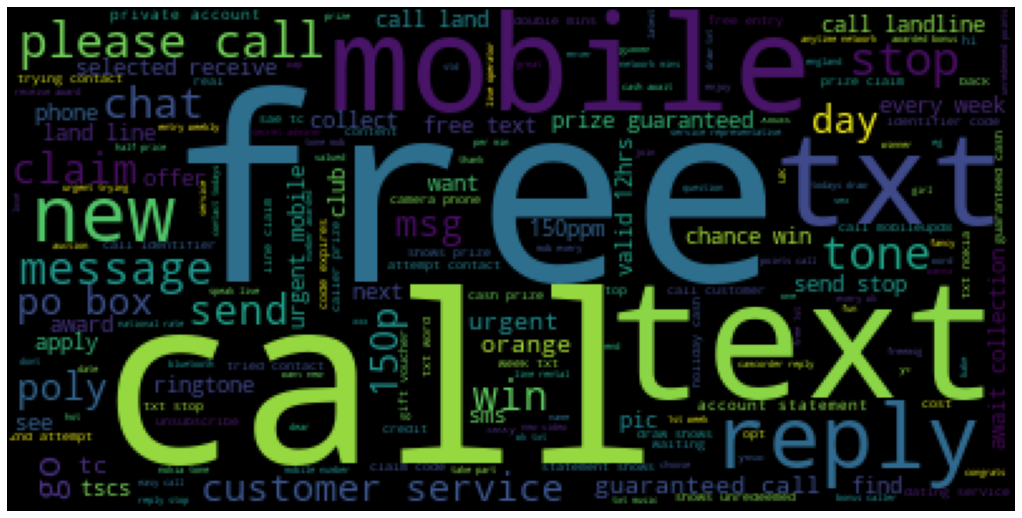

In [22]:
plt.figure(figsize=(14,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### **Train Test Split**

In [23]:
x_train, x_test, y_train, y_test = train_test_split(spam_dataset['processed_text'], spam_dataset['label'], test_size=0.3, random_state=0, shuffle=True, stratify=spam_dataset['label'])

In [24]:
x_train.shape

(3900,)

In [25]:
## spam message from training dataset
x_train[1128]

'hmv quiz cashbalance currently å£500 maximize cashin send hmv1 86688 150pmsg'

In [26]:
## output for x_train
y_train[1128]

1

# **Bag of Words text Classifier**

In [27]:
## Bag of words creation
vectorizer = TfidfVectorizer()
word_vectors = vectorizer.fit_transform(x_train)

In [28]:
word_vectors.shape

(3900, 7570)

In [29]:
## TfidfVectorizer - Transforms text to feature vectors
## sklearn has created sparse metrix with 3572 columns 
word_vectors

<3900x7570 sparse matrix of type '<class 'numpy.float64'>'
	with 32697 stored elements in Compressed Sparse Row format>

In [30]:
## Using pipeline to vectorize and then feeding the vectors to RF classifier 
model_BOW_classifier = Pipeline([('tfidf',TfidfVectorizer() ),('clf',RandomForestClassifier(n_estimators=100, n_jobs=-1, verbose=1))])

In [31]:
## fitting the classifier to training set
model_BOW_classifier.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier(n_jobs=-1, verbose=1))])

In [32]:
# predicting the test set result
y_pred = model_BOW_classifier.predict(x_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


In [33]:
# making the confusion matrix
confusion_matrix(y_test, y_pred)

array([[1448,    0],
       [  54,  170]])

In [34]:
## As per confusion matrix, 223 ham messages have classified rightly as ham only 2 are classified in correctly as spam
## 31 spam messages have classified wrongly as ham and rest 193 are classified in correctly as spam

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1448
           1       1.00      0.76      0.86       224

    accuracy                           0.97      1672
   macro avg       0.98      0.88      0.92      1672
weighted avg       0.97      0.97      0.97      1672



In [36]:
accuracy_score(y_test, y_pred)

0.9677033492822966

#### Accuracy is poor metrics here as the data is skewed.
#### There are more ham messages than spam so if we guess ham correctly it will improve accuracy score largely.

#### Thus the accurate metric to use is f1 score as it will consider the accuracy in both the classes spam as well as ham

# **LSTM with pretrained Word2Vec Word Embeddings**

In [37]:
x = [d.split() for d in spam_dataset['processed_text']]
x

[['go',
  'jurong',
  'point',
  'crazy',
  'available',
  'bugis',
  'n',
  'great',
  'world',
  'la',
  'e',
  'buffet',
  'cine',
  'got',
  'amore',
  'wat'],
 ['ok', 'lar', 'joking', 'wif', 'oni'],
 ['free',
  'entry',
  'wkly',
  'comp',
  'win',
  'fa',
  'cup',
  'final',
  'tkts',
  '21st',
  'may',
  '2005',
  'text',
  'fa',
  '87121',
  'receive',
  'entry',
  'questionstd',
  'txt',
  'ratetcs',
  'apply',
  '08452810075over18s'],
 ['dun', 'say', 'early', 'hor', 'c', 'already', 'say'],
 ['nah', 'dont', 'think', 'goes', 'usf', 'lives', 'around', 'though'],
 ['freemsg',
  'hey',
  'darling',
  'weeks',
  'word',
  'back',
  'id',
  'like',
  'fun',
  'still',
  'tb',
  'ok',
  'xxx',
  'std',
  'chgs',
  'send',
  'å£150',
  'rcv'],
 ['even', 'brother', 'like', 'speak', 'treat', 'like', 'aids', 'patent'],
 ['per',
  'request',
  'melle',
  'melle',
  'oru',
  'minnaminunginte',
  'nurungu',
  'vettam',
  'set',
  'callertune',
  'callers',
  'press',
  'copy',
  'friends',


In [38]:
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=x, size=DIM, window=5, min_count=1)

In [39]:
## vocabulary length = number of unique vecors in space
len(w2v_model.wv.vocab)

9418

In [40]:
## vector for word free
w2v_model.wv['free']

array([-0.15077926, -0.01606899, -0.3022977 , -0.03566415, -0.05393235,
        0.18218915,  0.28414437,  0.00411271,  0.25457537,  0.2225152 ,
       -0.10775727, -0.3085648 ,  0.16487326,  0.28572264, -0.19336303,
       -0.01909832,  0.35421425,  0.24171406, -0.16545855, -0.027235  ,
       -0.17611255,  0.16753794, -0.03359067, -0.2049274 ,  0.05889157,
        0.17600924, -0.2240653 ,  0.3935146 ,  0.34473908, -0.24965475,
        0.10945315, -0.24017724, -0.06149623, -0.24835892, -0.13960445,
        0.07181238, -0.20557232,  0.04785035, -0.21720755, -0.27883223,
        0.12260814, -0.08929097, -0.14438635, -0.18273796, -0.1516709 ,
        0.15856108,  0.11345709,  0.14590842, -0.11343416, -0.11935113,
       -0.16350445, -0.04346927, -0.16397065, -0.09789573,  0.30984038,
        0.19690943,  0.24191718, -0.08157786, -0.07083201,  0.00848158,
       -0.09023941,  0.11726016,  0.18094648, -0.2299839 ,  0.08055226,
        0.10727417,  0.27104115, -0.15488699, -0.12857585, -0.05

In [41]:
w2v_model.wv.most_similar('call')

[('free', 0.9997166991233826),
 ('get', 0.9996945858001709),
 ('go', 0.999673068523407),
 ('text', 0.9996525645256042),
 ('txt', 0.9996334314346313),
 ('like', 0.9996277689933777),
 ('got', 0.9996271133422852),
 ('one', 0.9996227622032166),
 ('r', 0.999617874622345),
 ('n', 0.9996163845062256)]

In [42]:
## feed these word vectors as initial weights to machine learning models
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)

In [43]:
x = tokenizer.texts_to_sequences(x)
x

[[4,
  4230,
  673,
  591,
  559,
  1119,
  33,
  53,
  251,
  1120,
  76,
  2760,
  1121,
  10,
  4231,
  63],
 [5, 212, 1271, 332, 1704],
 [7,
  347,
  627,
  778,
  97,
  1705,
  1006,
  503,
  1706,
  2084,
  169,
  2085,
  19,
  1705,
  1707,
  213,
  347,
  2761,
  23,
  2762,
  276,
  2763],
 [139, 68, 252, 2764, 80, 69, 68],
 [828, 3, 40, 348, 779, 1708, 116, 349],
 [725,
  54,
  1461,
  478,
  240,
  30,
  262,
  9,
  277,
  28,
  1709,
  5,
  263,
  911,
  4232,
  18,
  333,
  2765],
 [117, 479, 9, 253, 560, 9, 4233, 4234],
 [128,
  1007,
  1272,
  1272,
  1710,
  2086,
  2087,
  2088,
  456,
  829,
  1462,
  830,
  912,
  129,
  829],
 [561,
  674,
  305,
  130,
  306,
  2766,
  1122,
  66,
  831,
  49,
  1,
  2767,
  49,
  294,
  2768,
  392,
  628,
  432],
 [35,
  913,
  675,
  29,
  1008,
  376,
  203,
  433,
  726,
  227,
  7,
  1,
  35,
  376,
  1123,
  7,
  2769],
 [131, 24, 121, 3, 17, 173, 183, 1009, 122, 98, 90, 4235, 307, 34],
 [1711,
  2770,
  97,
  91,
  562,
  2

In [44]:
tokenizer.word_index

{'call': 1,
 'get': 2,
 'dont': 3,
 'go': 4,
 'ok': 5,
 'ltgt': 6,
 'free': 7,
 'know': 8,
 'like': 9,
 'got': 10,
 'ill': 11,
 'good': 12,
 'come': 13,
 'time': 14,
 'day': 15,
 'love': 16,
 'want': 17,
 'send': 18,
 'text': 19,
 'going': 20,
 'one': 21,
 'need': 22,
 'txt': 23,
 'home': 24,
 'lor': 25,
 'see': 26,
 'sorry': 27,
 'still': 28,
 'r': 29,
 'back': 30,
 'stop': 31,
 'reply': 32,
 'n': 33,
 'today': 34,
 'mobile': 35,
 'tell': 36,
 'new': 37,
 'later': 38,
 'well': 39,
 'think': 40,
 'da': 41,
 'hi': 42,
 'please': 43,
 'take': 44,
 'phone': 45,
 'cant': 46,
 'ì': 47,
 'week': 48,
 'claim': 49,
 'much': 50,
 'night': 51,
 'oh': 52,
 'great': 53,
 'hey': 54,
 'dear': 55,
 'pls': 56,
 'happy': 57,
 'hope': 58,
 'make': 59,
 'way': 60,
 'work': 61,
 'give': 62,
 'wat': 63,
 'thats': 64,
 'number': 65,
 'prize': 66,
 'right': 67,
 'say': 68,
 'already': 69,
 'tomorrow': 70,
 'ask': 71,
 'yes': 72,
 'really': 73,
 'yeah': 74,
 'said': 75,
 'e': 76,
 'message': 77,
 'amp': 78,
 

(array([4.510e+02, 1.783e+03, 7.930e+02, 7.190e+02, 5.250e+02, 4.050e+02,
        4.630e+02, 2.640e+02, 8.000e+01, 2.800e+01, 2.000e+01, 7.000e+00,
        7.000e+00, 6.000e+00, 7.000e+00, 1.000e+00, 4.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.        ,  2.66666667,  5.33333333,  8.        , 10.66666667,
        13.33333333, 16.        , 18.66666667, 21.33333333, 24.        ,
        26.66666667, 29.33333333, 32.        , 34.66666667, 37.33333333,
        40.        , 42.66666667, 45.33333333, 48.        , 50.66666667,
        53.33333333, 56.        , 58.66666667, 61.33333333, 64.        ,
        66.66666667, 69.33333333, 72.        , 74.66666667, 77.33333333,
        80.        ]),
 <a list of 30 Patch objects>)

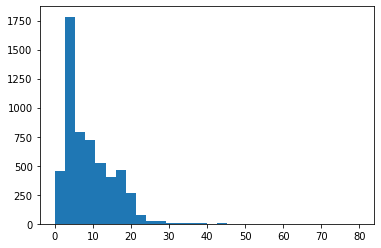

In [45]:
plt.hist([len(x) for x in x], bins =30)

In [46]:
#### As per histomram the max 30 words are present in the messages, so we can keep maxlen = 30 

In [47]:
array = np.array([len(x) for x in x])
len(array[array>70])

2

In [48]:
### As we have almost all sentences with 30 word count per sentence, truncate the sequence lenght with maxlen = 50

In [49]:
x = pad_sequences(x, maxlen=30)
x.shape

(5572, 30)

In [50]:
VOAB_LEN = len(tokenizer.word_index)+1
vocab = tokenizer.word_index

In [51]:
print(VOAB_LEN)

9419


In [52]:
## getting initial weights from word2vec model
embedding_vectors = np.zeros((VOAB_LEN, 100))

for word, i in vocab.items():
  embedding_vectors[i] = w2v_model.wv[word]

In [53]:
embedding_vectors.shape

(9419, 100)

In [54]:
model_LSTM = Sequential()

# Add an Embedding layer expecting input vocab of size VOAB_LEN, and
# output embedding dimension of size 1DIM =100.
model_LSTM.add(Embedding(input_dim = VOAB_LEN, output_dim = DIM, weights = [embedding_vectors], input_length = 30, trainable = False))

# Add a LSTM layer with 128 internal units.
model_LSTM.add(LSTM(128))

# Add a Dense layer with 1 unit
model_LSTM.add(Dense(1, activation='sigmoid'))

# Compile the model
model_LSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [55]:
#### Train Test split
x_train, x_test, y_train, y_test = train_test_split(x, spam_dataset['label'])

In [56]:
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           941900    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,059,277
Trainable params: 117,377
Non-trainable params: 941,900
_________________________________________________________________


In [57]:
model_LSTM_plt = model_LSTM.fit(x_train, y_train, validation_split=0.3, epochs=6, verbose=1, batch_size = 128)

Epoch 1/6
23/23 [==============================] - 8s 84ms/step - loss: 0.5040 - acc: 0.8636 - val_loss: 0.3405 - val_acc: 0.8700
Epoch 2/6
23/23 [==============================] - 0s 14ms/step - loss: 0.2936 - acc: 0.8721 - val_loss: 0.2834 - val_acc: 0.8804
Epoch 3/6
23/23 [==============================] - 0s 13ms/step - loss: 0.2722 - acc: 0.8793 - val_loss: 0.2813 - val_acc: 0.8772
Epoch 4/6
23/23 [==============================] - 0s 14ms/step - loss: 0.2658 - acc: 0.8824 - val_loss: 0.2828 - val_acc: 0.8748
Epoch 5/6
23/23 [==============================] - 0s 14ms/step - loss: 0.2595 - acc: 0.8841 - val_loss: 0.2809 - val_acc: 0.8724
Epoch 6/6
23/23 [==============================] - 0s 15ms/step - loss: 0.2563 - acc: 0.8916 - val_loss: 0.2705 - val_acc: 0.8756


#### After training model for 6 epochs accuracy of 91% is achieved to detecting spam/ham messages.

In [58]:
y_pred = (model_LSTM.predict(x_test) >= 0.5).astype(int)

#### Converting probability score to 0 and 1 labels for y pred

In [59]:
accuracy_score(y_test, y_pred)

0.8786791098348887

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1204
           1       0.57      0.41      0.48       189

    accuracy                           0.88      1393
   macro avg       0.74      0.68      0.70      1393
weighted avg       0.87      0.88      0.87      1393



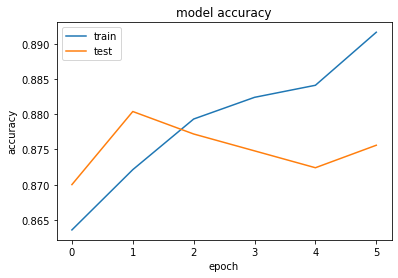

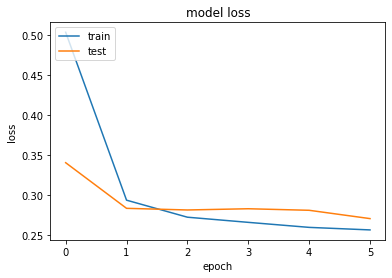

In [61]:
def show_performance_plot(mdl):
  #show the model accuracy
  plt.plot(mdl.history['acc'])
  plt.plot(mdl.history['val_acc'])

  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()
  #show model loss
  plt.plot(mdl.history['loss'])
  plt.plot(mdl.history['val_loss'])

  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

show_performance_plot(model_LSTM_plt)

# **Bi-directional LSTM**

In [62]:
model_bidirectional = Sequential()

# Add an Embedding layer expecting input vocab of size VOAB_LEN, and
# output embedding dimension of size 1DIM =100.
model_bidirectional.add(Embedding(input_dim = VOAB_LEN, output_dim = DIM, weights = [embedding_vectors], input_length = 30, trainable = False))

# Add a LSTM layer with 128 internal units.
model_bidirectional.add(Bidirectional((LSTM(units = 128))))
model_bidirectional.add(Dropout(0.5))

# Add a Dense layer with 1 unit
model_bidirectional.add(Dense(1, activation='sigmoid'))
model_bidirectional.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])


In [63]:
#### Train Test split
x_train, x_test, y_train, y_test = train_test_split(x, spam_dataset['label'])

In [64]:
model_bidirectional.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 100)           941900    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,176,653
Trainable params: 234,753
Non-trainable params: 941,900
_________________________________________________________________


In [65]:
model_bidirectional_plt = model_bidirectional.fit(x_train, y_train, validation_split=0.3, epochs=6, verbose=1, batch_size = 128)

Epoch 1/6
23/23 [==============================] - 4s 52ms/step - loss: 0.1611 - acc: 0.8492 - val_loss: 0.1337 - val_acc: 0.8652
Epoch 2/6
23/23 [==============================] - 0s 13ms/step - loss: 0.1225 - acc: 0.8656 - val_loss: 0.1077 - val_acc: 0.8652
Epoch 3/6
23/23 [==============================] - 0s 12ms/step - loss: 0.0967 - acc: 0.8704 - val_loss: 0.0859 - val_acc: 0.8836
Epoch 4/6
23/23 [==============================] - 0s 12ms/step - loss: 0.0906 - acc: 0.8711 - val_loss: 0.0851 - val_acc: 0.8740
Epoch 5/6
23/23 [==============================] - 0s 11ms/step - loss: 0.0868 - acc: 0.8759 - val_loss: 0.0820 - val_acc: 0.8884
Epoch 6/6
23/23 [==============================] - 0s 12ms/step - loss: 0.0847 - acc: 0.8790 - val_loss: 0.0800 - val_acc: 0.8947


In [66]:
y_pred = (model_bidirectional.predict(x_test) >= 0.5).astype(int)

In [67]:
accuracy_score(y_test, y_pred)

0.8880114860014358

In [68]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      1208
           1       0.62      0.41      0.49       185

    accuracy                           0.89      1393
   macro avg       0.77      0.69      0.72      1393
weighted avg       0.87      0.89      0.88      1393



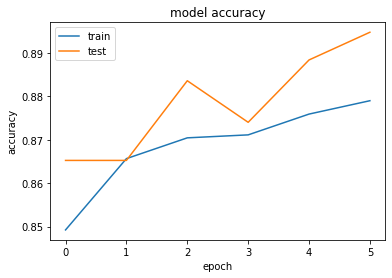

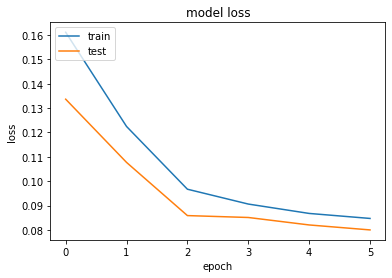

In [69]:
def show_performance_plot(mdl):
  #show the model accuracy
  plt.plot(mdl.history['acc'])
  plt.plot(mdl.history['val_acc'])

  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()
  #show model loss
  plt.plot(mdl.history['loss'])
  plt.plot(mdl.history['val_loss'])

  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

show_performance_plot(model_bidirectional_plt)

# **Bi-directional LSTM with attention layer**

In [70]:
model_bidirectional_attention_layer = Sequential()

# Add an Embedding layer expecting input vocab of size VOAB_LEN, and
# output embedding dimension of size 1DIM =100.
model_bidirectional_attention_layer.add(Embedding(input_dim = VOAB_LEN, output_dim = DIM, weights = [embedding_vectors], input_length = 30, trainable = False))

# Add a LSTM layer with 128 internal units.
model_bidirectional_attention_layer.add(Bidirectional((LSTM(units = 128))))
model_bidirectional_attention_layer.add(Dropout(0.5))
# Add a Dense layer with 1 unit

model_bidirectional_attention_layer.add(Activation('softmax')) 
model_bidirectional_attention_layer.add(Dense(1, activation='sigmoid'))

# attention layer
#model_bidirectional_attention_layer.add(Activation('softmax')) 

model_bidirectional_attention_layer.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])



In [71]:
#### Train Test split
x_train, x_test, y_train, y_test = train_test_split(x, spam_dataset['label'])

In [72]:
model_bidirectional_attention_layer.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 30, 100)           941900    
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,176,653
Trainable params: 234,753
Non-trainable params: 941,900
________________________________________

In [73]:
model_bidirectional_attention_layer_plt = model_bidirectional_attention_layer.fit(x_train, y_train, validation_split=0.3, epochs=6, verbose=1, batch_size = 128)

Epoch 1/6
23/23 [==============================] - 4s 48ms/step - loss: 0.2448 - acc: 0.8564 - val_loss: 0.2364 - val_acc: 0.8748
Epoch 2/6
23/23 [==============================] - 0s 13ms/step - loss: 0.2302 - acc: 0.8564 - val_loss: 0.2232 - val_acc: 0.8748
Epoch 3/6
23/23 [==============================] - 0s 12ms/step - loss: 0.2202 - acc: 0.8564 - val_loss: 0.2150 - val_acc: 0.8748
Epoch 4/6
23/23 [==============================] - 0s 12ms/step - loss: 0.2131 - acc: 0.8564 - val_loss: 0.2079 - val_acc: 0.8748
Epoch 5/6
23/23 [==============================] - 0s 12ms/step - loss: 0.2067 - acc: 0.8564 - val_loss: 0.2013 - val_acc: 0.8748
Epoch 6/6
23/23 [==============================] - 0s 12ms/step - loss: 0.2008 - acc: 0.8564 - val_loss: 0.1953 - val_acc: 0.8748


In [74]:
y_pred = (model_bidirectional_attention_layer.predict(x_test) >= 0.5).astype(int)

In [75]:
accuracy_score(y_test, y_pred)

0.8779612347451543

In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1223
           1       0.00      0.00      0.00       170

    accuracy                           0.88      1393
   macro avg       0.44      0.50      0.47      1393
weighted avg       0.77      0.88      0.82      1393



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


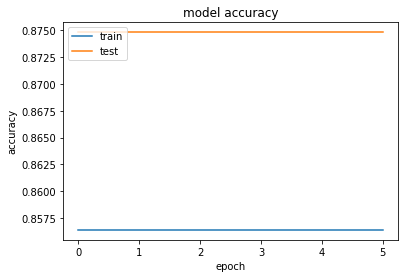

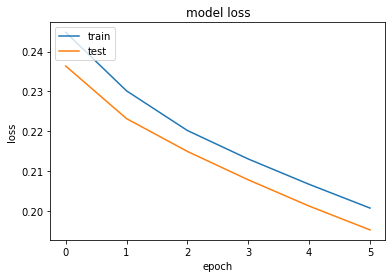

In [77]:
def show_performance_plot(mdl):
  #show the model accuracy
  plt.plot(mdl.history['acc'])
  plt.plot(mdl.history['val_acc'])

  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()
  #show model loss
  plt.plot(mdl.history['loss'])
  plt.plot(mdl.history['val_loss'])

  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

show_performance_plot(model_bidirectional_attention_layer_plt)

# **Compare and conclude**

Bag of worsds tfidf classifier gave f1 score of 98%\
LSTM gave improved f1 score of 93%\
Bidirectional LSTM gave f1 score = 94%\
Bidirectional LSTM with attention layer with f1 score = 94%\
Overall as we add the Bidirectional LSTM/ attention layer the accuracy keeps on improving for ML model.

#### Machine Learning Production Pipeline

Step 1: Data Ingesion\
Step 2: Data Validation\
Step 3: Data Transform\
Step 4: Model Training\
Step 5: Model Analysis\
Step 6: Production model

The data pipleline calls for data first to be gathered and ingested by Data Engineers. 
This data is validated, cleaned and label encoded appropriately.
Further it is transformed into a format that can be used for training.

Then we train model and upon completion they are arnalysed using accuracy, loss curves.

Once the acceptable metrics are outputed then we call it as production ready model. Lastly model is deployed either **on demand web server/batch process/ mobile**, IoT devices.


---

TensorFlow Serving is a flexible, high-performance serving system for machine learning models, designed for production environments. TensorFlow Serving makes it easy to deploy new algorithms and experiments, while keeping the same server architecture and APIs. TensorFlow Serving provides out-of-the-box integration with TensorFlow models, but can be easily extended to serve other types of models and data.


It basically provides the infrastructure for hosting your model on a server.
Client applications can use HTTP to send requests to this server with data payload. Data is fed to ML model which will fetch the results and return them to client. (Google Cloud)

---

TensorFlow Extended (TFX) | ML Production Pipelines

Build and manage end-to-end production ML pipelines. TFX components enable scalable, high-performance data processing with data stored on google cloud.

---

AWS cloud 

Amazon SageMaker provides purpose-built tools for machine learning operations (MLOps) to help you automate and standardize processes across the ML lifecycle. Using SageMaker MLOps tools, you can easily train, test, troubleshoot, deploy, and govern ML models at scale to boost productivity of data scientists and ML engineers while maintaining model performance in production.

---

This is the simplest way to deploy machine learning models as web services.
Using opensource python flask web framework and hosting it on above mentioned cloud services like AWS / Google / Microsoft cloud.
 
The most important point is to persist model. The environment where we deploy the application is often different from where we train them. Training usually requires a different set of resources. Thus this separation helps organizations optimize their budget and efforts.

Scikit-learn offers python specific serialization that makes model persistence and restoration effortless. we can store the trained model in a pickle file and serve the persisted model using a web framework like REST API using Flask. This is **on demand ML models**.

For **batch models**, we can save them using cron jobs/ apache Airflow.

For **mobile devices** deployment, we can use the TensorFlow Lite library on Android to simplify our TensorFlow model. 
TensorFlow Lite is an open-source software library for mobile and embedded devices.

